In [1]:
import json

root_path = "../Dataset/MPII/images/"
with open("../Dataset/MPII/annot/train.json", "r") as f:
    data = json.load(f)

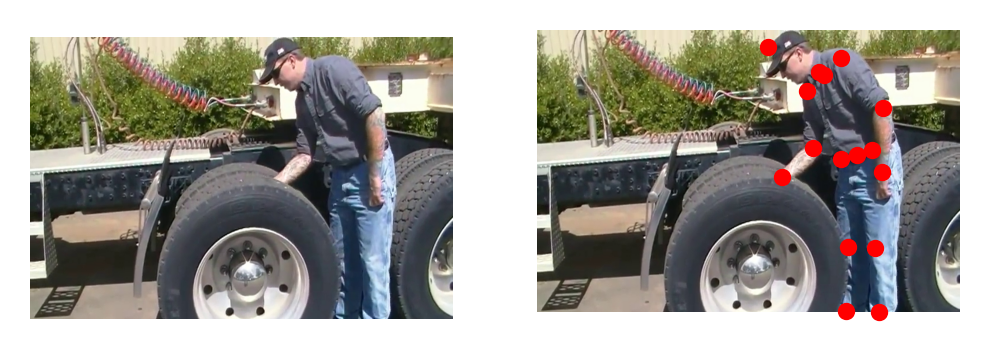

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (4, 3)
plt.rcParams["figure.dpi"] = 300

i = 25

img = Image.open(root_path + data[i]["image"])
joint = np.array(data[i]["joints"]).reshape(-1, 2)
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(img)
plt.axis("off")
plt.scatter(joint[:, 0], joint[:, 1], s=10, c="r")
plt.show()

In [3]:
root_path + data[i]["image"]

'../Dataset/MPII/images/036636184.jpg'

In [5]:
print(data[i])

{'joints_vis': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[525.0, 478.0], [529.0, 369.0], [517.0, 220.0], [570.0, 204.0], [574.0, 371.0], [581.0, 480.0], [544.0, 212.0], [488.0, 76.0], [479.0873, 71.5436], [392.9127, 28.4564], [416.0, 251.0], [469.0, 201.0], [459.0, 104.0], [516.0, 48.0], [588.0, 132.0], [587.0, 242.0]], 'image': '036636184.jpg', 'scale': 2.890381, 'center': [472.0, 245.0]}


In [34]:
import cv2


def generate_heatmap(image, label, sigma=5):
    heatmap = np.zeros((image.shape[:2]))
    for p in label:
        heatmap[int(p[1]), int(p[0])] = 1
    heatmap = cv2.GaussianBlur(heatmap, (13, 13), sigma)
    am = np.amax(heatmap)
    heatmap /= am / 255
    return heatmap


img = np.array(img)
heatmap = generate_heatmap(img, joint)

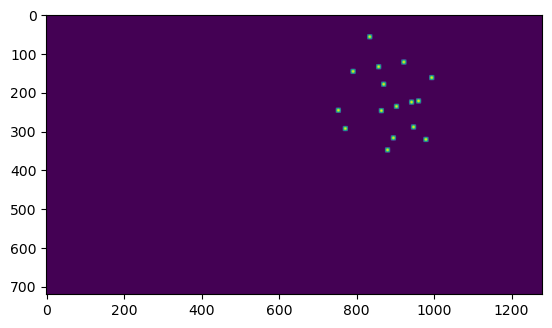

In [35]:
plt.imshow(heatmap)

In [46]:
import torch


def calculate_pckh_torch(prediction, ground_truth, head_segment_length=0.5):
    """
    Calculate PCKh@0.5 metric for human pose estimation using PyTorch.

    :param prediction: PyTorch tensor of predicted keypoints, shape (b, num_joints, h, w)
    :param ground_truth: PyTorch tensor of ground truth keypoints, shape (b, num_joints, h, w)
    :param head_segment_length: length of the head segment
    :return: PCKh@0.5 score
    """
    threshold = 0.5 * head_segment_length
    batch_size, num_joints, height, width = prediction.shape

    # Get the coordinates of the maximum values (keypoints) in the heatmaps
    pred_coords = torch.argmax(prediction.view(batch_size, num_joints, -1), dim=2)
    gt_coords = torch.argmax(ground_truth.view(batch_size, num_joints, -1), dim=2)

    pred_coords = torch.stack((pred_coords // width, pred_coords % width), dim=2)
    gt_coords = torch.stack((gt_coords // width, gt_coords % width), dim=2)

    # Calculate the Euclidean distance between predicted and ground truth keypoints
    distances = torch.norm(pred_coords.float() - gt_coords.float(), dim=2)

    # Calculate PCKh@0.5
    correct_keypoints = (distances <= threshold).float().sum()
    total_keypoints = torch.numel(distances)

    return correct_keypoints / total_keypoints


# Example usage
prediction_tensor = torch.rand((1, 16, 64, 64))
ground_truth_tensor = torch.rand((1, 16, 64, 64))
pckh_score = calculate_pckh_torch(prediction_tensor, ground_truth_tensor)

In [6]:
import torch.nn as nn
import torch

x = torch.rand(1, 3, 224, 224)
nn.AvgPool2d(kernel_size=9, stride=8, padding=1)(x).shape

torch.Size([1, 3, 28, 28])

In [2]:
import torch.nn as nn
import torch

a = nn.Embedding(10, 512)
b = torch.rand(20, 512)

d = (
    torch.sum(b**2, dim=1, keepdim=True)
    + torch.sum(a.weight**2, dim=1)
    - 2 * torch.matmul(b, a.weight.t())
)

# find closest encodings
min_encoding_indices = torch.argmin(d, dim=1).unsqueeze(1)
min_encodings = torch.zeros(min_encoding_indices.shape[0], 10)
min_encodings.scatter_(1, min_encoding_indices, 1)

# get quantized latent vectors
z_q = torch.matmul(min_encodings, a.weight).view(b.shape)

In [9]:
e_mean = torch.mean(min_encodings, dim=0)
perplexity = torch.exp(-torch.sum(e_mean * torch.log(e_mean + 1e-10)))

In [11]:
e_mean, perplexity

(tensor([0.1000, 0.0000, 0.8500, 0.0000, 0.0000, 0.0000, 0.0000, 0.0500, 0.0000,
         0.0000]),
 tensor(1.6790))